Creating a (pseudo)-random population distribution.
Enter a population size (between 1 and 10^6): 1000

The population mean is: 38.035
The population stddev is: 988.041
This is the population distribution:


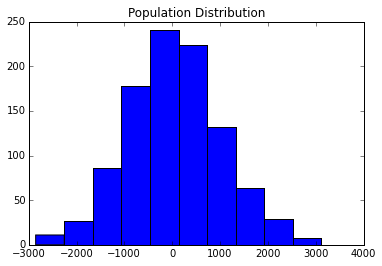

Enter the sample size (to be drawn with replacement, between 1 and 10^6): 100
Enter the confidence interval alpha as a decimal, between 0 and 0.999999: 0.9
Enter the number of times to repeat the experiment (between 1 and 10^6): 100


The mean of the sample means is: 40.332
This is the sample mean distribution:


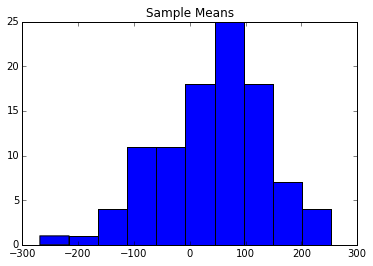

2.a/Challenge.1) After drawing 100 samples of size 100, the approx. standard error of the sampling distribution are:
-------------------------------------------  -------
Approximation from sample mean distribution  96.1123
Average of sample std errors                 98.1404
Population stddev / sqrt(sample size)        98.8041
-------------------------------------------  -------

2.b) In these samples, the 90.00% confidence interval captured the population mean 91 times, which is 91.00% of the procedures

Challenge.3.i) The minimal interval (max lower, min upper) is (73.924, -122.680).
It failed to capture the population mean (38.035), and it is empty.

Chanllenge.3.ii) The maximal interval (min lower, max upper) is (-414.789, 433.786).
It captured the population mean (38.035).


KeyboardInterrupt: 

In [5]:
# Code for the Sampling / RTTM / Confidence Intervals Assignment
# Adapted from CLT.py provded for FA 2.03.1
# If some of the line formattings look weird / short
# It is because I tried to format it to fit well in the text


%matplotlib inline
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy import stats
import re
from tqdm import tqdm
from tabulate import tabulate


DECIMAL_NUMBER_PATTERN = '^[\d\.]+$'


def create_uniform_population(size, size_multiplier=1000):
    return size_multiplier * np.random.random_sample((size, ))


def create_beta_population(size, size_multiplier=1000, a=0.5, b=0.5):
    return size_multiplier * np.random.beta(a, b, (size, ))


def create_normal_population(size, mean=0, std_dev=1, size_multiplier=1000):
    return size_multiplier * np.random.normal(mean, std_dev, size)
    

def graph_distribution(distribution, name):
    plt.hist(distribution)
    plt.title(name)
    plt.show()

    
def sample_procedure(population, sample_size, alpha):
    pop_mean = np.mean(population)
    pop_stddev = np.std(population)
    
    sample_repeats = read_number_from_user(
        "Enter the number of times to repeat the experiment (between 1 and 10^6): ", 
        int, 1, 10**6)
    sample_means = []
    sample_std_errors = []
    ci_capture_count = 0
    
    min_lower = None
    max_lower = None
    min_upper = None
    max_upper = None
    
    # tqdm is used to print progress, useful for large repetitions
    for _ in tqdm(xrange(sample_repeats)):
        sample = np.random.choice(population, (sample_size, ))
        sample_mean = np.mean(sample)
        sample_means.append(sample_mean)
        
        # Challenge.a - calculation of individual sample standard errors
         # ddof=1 applies Bessel's correction
        sample_std_error = np.std(sample, ddof=1) / (sample_size ** 0.5)
        sample_std_errors.append(sample_std_error)
        
        # 2.b - keeping track of CIs, and whether or not they capture the pop. mean
        lower, upper = stats.t.interval(alpha, sample_size - 1, 
                                        sample_mean, sample_std_error)
        if lower <= pop_mean <= upper:
            ci_capture_count += 1
            
        # Challenge.c - tracking minimal and maximal lower and upper bounds
        if not min_lower or lower < min_lower:
            min_lower = lower
        if not max_lower or lower > max_lower:
            max_lower = lower
        
        if not min_upper or upper < min_upper:
            min_upper = upper
        if not max_upper or upper > max_upper:
            max_upper = upper
    
    print 'The mean of the sample means is: {mean:.3f}'.format(
        mean=np.mean(sample_means))
    print 'This is the sample mean distribution:'
    graph_distribution(sample_means, 'Sample Means')
    
    # 2.a, Challenge.a - output
    se_mean_output = '2.a/Challenge.1) After drawing {k} samples of size {n}, '+\
            'the approx. standard error of the sampling distribution are:'
    print se_mean_output.format(k=sample_repeats, n=sample_size)
                                
    se_mean_approximations = [
        # Applying Bessel's correction the first as we're approximating from a sample
        ('Approximation from sample mean distribution', np.std(sample_means, ddof=1)), 
        ('Average of sample std errors', np.mean(sample_std_errors)),
        ('Population stddev / sqrt(sample size)', pop_stddev / (sample_size ** 0.5))]
    print tabulate(se_mean_approximations)
    
    # 2.b - output
    ci_output = '\n2.b) In these samples, the {alpha:.2f}% confidence interval captured '+\
        'the population mean {capture_count} times, '+\
        'which is {capture_percent:.2f}% of the procedures'
    print ci_output.format(alpha=alpha*100, capture_count=ci_capture_count, 
                           capture_percent=float(ci_capture_count)*100/sample_repeats)
    
    # Challenge.c - output
    challenge_output = '\nChallenge.3.i) The minimal interval '+\
        '(max lower, min upper) is ({max_lower:.3f}, {min_upper:.3f}).\n'+\
        'It {capture} the population mean ({pop_mean:.3f}), and it is {empty}.'
            
    # the (expression) and ValueIfTrue or ValueIfFalse syntax behaves as a ternary:
    # in other languages, if often looks like (expression) ? ValueIfTrue : ValueIfFalse
    capture = (max_lower <= pop_mean <= min_upper) and 'captured' or 'failed to capture'
    empty = (min_upper <= max_lower) and 'empty' or 'not empty'
    print challenge_output.format(max_lower=max_lower, min_upper=min_upper, 
                                  capture=capture, empty=empty, pop_mean=pop_mean)
    
    more_challenge = '\nChanllenge.3.ii) The maximal interval '+\
        '(min lower, max upper) is ({min_lower:.3f}, {max_upper:.3f}).\n' +\
        'It {capture} the population mean ({pop_mean:.3f}).'
    capture = (min_lower <= pop_mean <= max_upper) and 'captured' or 'failed to capture'
    print more_challenge.format(min_lower=min_lower, max_upper=max_upper, 
                                capture=capture, pop_mean=pop_mean)
    
    
#####################################


def read_number_from_user(prompt, type_func, min_value, max_value):
    value = min_value - 1
    while not (min_value <= value <= max_value):
        raw_value = raw_input(prompt)
        if re.match(DECIMAL_NUMBER_PATTERN, raw_value):
            value = type_func(raw_value)
        
    return value


def read_letter_from_user(prompt, options):
    letter = ''
    while not letter in options:
        letter = raw_input(prompt).strip().lower()
        
    return letter


def main():
    print 'Creating a (pseudo)-random population distribution.'
    population_size = read_number_from_user(
        'Enter a population size (between 1 and 10^6): ', int, 1, 10**6)
    
    # Challenge.b - support for different populations
    population = create_normal_population(population_size)
#     population = create_uniform_population(population_size)
#     population = create_beta_population(population_size)

    print
    print 'The population mean is: {mean:.3f}'.format(mean=np.mean(population))
    print 'The population stddev is: {stddev:.3f}'.format(stddev=np.std(population)) 
    print 'This is the population distribution:'
    graph_distribution(population, 'Population Distribution')

    sample_size = read_number_from_user(
        'Enter the sample size (to be drawn with replacement, between 1 and 10^6): ', 
        int, 1, 10**6)
    
    alpha = read_number_from_user(
        'Enter the confidence interval alpha as a decimal, between 0 and 0.999999: ', 
        float, 0, 0.999999)
    
    continue_sampling = True

    while continue_sampling:
        sample_procedure(population, sample_size, alpha)
        
        decision = read_letter_from_user(
            'Repeat sampling procedure? y / n: ', ('y', 'n'))
        
        continue_sampling = (decision == 'y')
        
main()